# 20260128: 實作NCSN+Annealing Langevin Sampling - 2D Spiral

1. 建構 NCSN (Model)：寫一個神經網路，輸入是 $(x, \sigma)$，輸出是 $\epsilon$ (或 Score)。 定義 Loss Function 來訓練它。
2. 實作 Algorithm 1 (Sampling)：寫一個函式，裡面有兩層迴圈。外層控制 $\sigma$ (Annealing)。內層跑 $T$ 次演算法中第 6 行的公式 (Langevin Step)。



---

# Model

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

def get_spiral_data(n_samples):
    theta = torch.sqrt(torch.rand(n_samples)) * 6 * np.pi 
    r = theta
    x = r * torch.cos(theta)
    y = r * torch.sin(theta)    
    data = torch.stack([x, y], dim=1)
    # 標準化到 [-1, 1] 附近
    return data / (6 * np.pi) 

# 初始化範圍建議：既然數據在 [-1, 1]，初始化可以灑在 [-1.2, 1.2]
# x_init = torch.rand(n_samples, 2) * 2.4 - 1.2

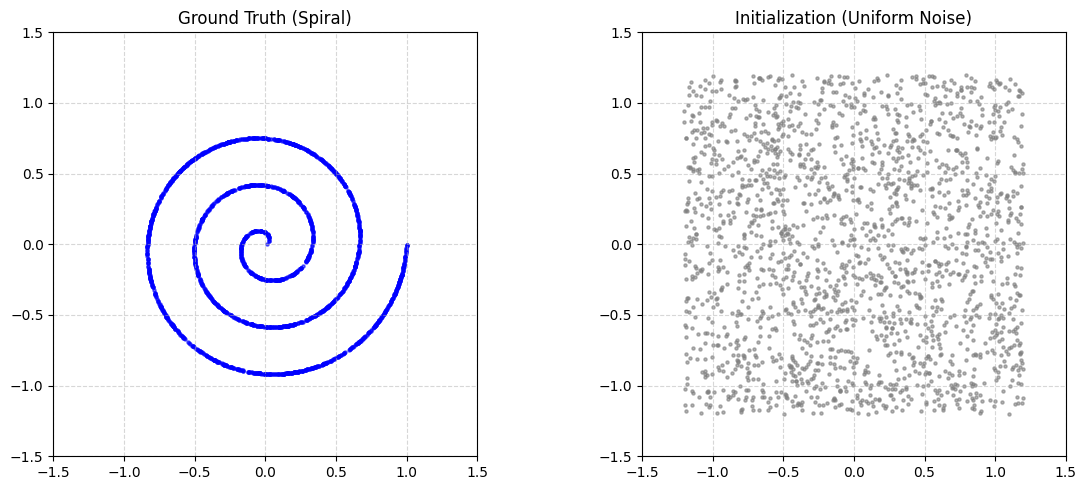

In [10]:
n_samples = 2000
ground_truth = get_spiral_data(n_samples)
x_init = torch.rand(n_samples, 2) * 2.4 - 1.2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(ground_truth[:, 0], ground_truth[:, 1], s=5, alpha=0.6, c='blue')
plt.title("Ground Truth (Spiral)")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal')

# 右圖：Initialization 範圍
plt.subplot(1, 2, 2)
plt.scatter(x_init[:, 0], x_init[:, 1], s=5, alpha=0.6, c='gray')
plt.title("Initialization (Uniform Noise)")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().set_aspect('equal')

plt.tight_layout()
plt.show()

In [14]:
class GaussianFourierProjection(torch.nn.Module):
    def __init__(self, embed_dim, scale=10.):
        super().__init__()
        self.W = torch.nn.Parameter(torch.randn(2, embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        # x shape: [batch, 2]
        x_proj = x @ self.W * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class NCSN_2D_Spiral(nn.Module):
    def __init__(self, hidden, num_layers, num_classes):
        super().__init__()
        # 2. 將輸入維度改為傅立葉特徵的維度 (例如 hidden)
        self.fourier_projection = GaussianFourierProjection(embed_dim=hidden)
        self.embed = nn.Embedding(num_classes, hidden) 
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Linear(hidden, hidden))
        self.fc_out = nn.Linear(hidden, 2) # 輸出仍為 2D 向量
        self.act = nn.SiLU()

    def forward(self, x, labels):
        # 將 (batch, 2) 映射到 (batch, hidden)
        h = self.fourier_projection(x)
        embed = self.embed(labels)
        h = self.act(h + embed) 
        
        for layer in self.layers:
            h = self.act(layer(h))
            
        return self.fc_out(h)

In [15]:
num_classes = 50
batch_size=2048
device = torch.device("cpu")
sigmas = torch.tensor(
    np.exp(np.linspace(np.log(5.0), np.log(0.005), num_classes)), # 數據在[-1, 1], sigma_max 設 5 夠用了
    dtype=torch.float32
).to(device)

model = NCSN_2D_Spiral(hidden=256, num_layers=4, num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)


# --- 修改 Loss 函數 ---
def spiral_dsm_loss(model, batch_size):
    # 使用你剛才定義的螺旋數據生成器
    x0 = get_spiral_data(batch_size).to(device)
    
    labels = torch.randint(0, num_classes, (batch_size,), device=device)
    used_sigmas = sigmas[labels].view(batch_size, 1) 
    
    noise = torch.randn_like(x0)
    x_tilde = x0 + used_sigmas * noise
    
    eps_pred = model(x_tilde, labels)
    
    # 根據 EDM 精神，你可以考慮加入 1/sigma 的權重，但基本 DSM 如下：
    loss = ((eps_pred - noise) ** 2).mean()
    return loss

In [19]:
# --- Training ---
print("Start Training...")
n_step=10000
loss_history = []
for epoch in range(1,n_step+1):
    model.train()
    loss = spiral_dsm_loss(model, batch_size)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    loss_history.append(loss.item())
    if epoch % 200 == 0:
        print(f"Epoch {epoch:4d} | Loss: {loss.item():6f}")


Start Training...
Epoch  200 | Loss: 0.693580
Epoch  400 | Loss: 0.705458
Epoch  600 | Loss: 0.699899
Epoch  800 | Loss: 0.664711
Epoch 1000 | Loss: 0.626810
Epoch 1200 | Loss: 0.588319
Epoch 1400 | Loss: 0.589530
Epoch 1600 | Loss: 0.591316
Epoch 1800 | Loss: 0.566223
Epoch 2000 | Loss: 0.542002
Epoch 2200 | Loss: 0.538609
Epoch 2400 | Loss: 0.561601
Epoch 2600 | Loss: 0.549884
Epoch 2800 | Loss: 0.579352
Epoch 3000 | Loss: 0.566560
Epoch 3200 | Loss: 0.522994
Epoch 3400 | Loss: 0.559595
Epoch 3600 | Loss: 0.510483
Epoch 3800 | Loss: 0.539945
Epoch 4000 | Loss: 0.558362
Epoch 4200 | Loss: 0.539099
Epoch 4400 | Loss: 0.531337
Epoch 4600 | Loss: 0.557262
Epoch 4800 | Loss: 0.570669
Epoch 5000 | Loss: 0.566268
Epoch 5200 | Loss: 0.516000
Epoch 5400 | Loss: 0.530271
Epoch 5600 | Loss: 0.511692
Epoch 5800 | Loss: 0.541129
Epoch 6000 | Loss: 0.490936
Epoch 6200 | Loss: 0.566610
Epoch 6400 | Loss: 0.518103
Epoch 6600 | Loss: 0.518704
Epoch 6800 | Loss: 0.553977
Epoch 7000 | Loss: 0.537818
Ep

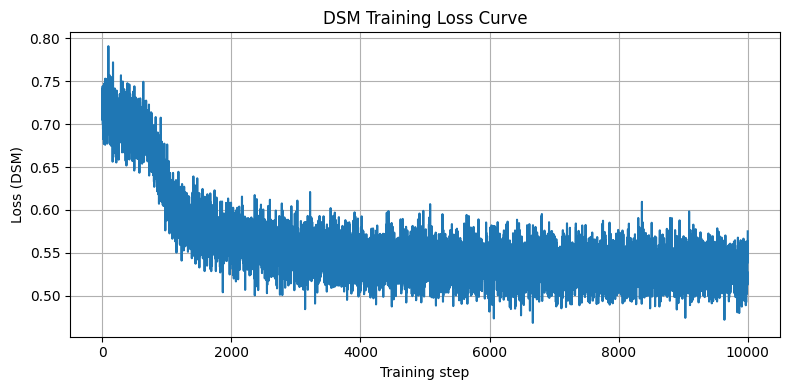

In [21]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

# Annealed Langevin Sampling

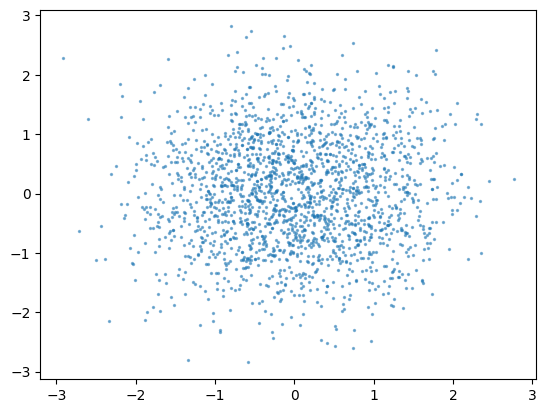

In [24]:
@torch.no_grad()
def sample_annealed_langevin(model, sigmas, n_samples=2000, steps_per_sigma=100, eps=1e-3):
    # 1. 在 [-1.2, 1.2] 範圍初始化
    x = torch.rand(n_samples, 2).to(device) * 2.4 - 1.2
    
    # 2. 從最大 sigma 降到最小 sigma
    for i in range(len(sigmas) - 1, -1, -1):
        sigma = sigmas[i]
        labels = torch.full((n_samples,), i, dtype=torch.long).to(device)
        
        # 每個 sigma 等級跑多次步長
        # 步長隨 sigma 縮放：step_lr = eps * (sigma / sigmas[-1])**2
        step_lr = eps * (sigma / sigmas[0])**2 
        
        for _ in range(steps_per_sigma):
            noise = torch.randn_like(x)
            grad = model(x, labels)
            
            # 這裡注意：因為模型預測的是 noise (eps)，score = -eps / sigma
            score = -grad / sigma
            
            x = x + 0.5 * step_lr * score + torch.sqrt(step_lr) * noise
            
    return x.cpu().numpy()

# 執行採樣並畫圖
samples = sample_annealed_langevin(model, sigmas)
plt.scatter(samples[:, 0], samples[:, 1], s=2, alpha=0.5)
plt.show()

如果要報告的話就用上面這組數據好了, Loss也收斂的不怎麼樣.....

In [29]:
def annealed_langevin_dynamics(score_model,sigmas, n_samples=1000, 
                                 # 預先定義好的 sigma sequence (從大到小)
                               steps_per_sigma=100, # 您的設定
                               eps=1e-3):           # 您的設定
    
    # 1. 初始化：從均勻分布或高斯分布開始 (筆記提到 'uniform 撒點範圍')
    # 如果是 SDE paper，通常從 N(0, I) 開始
    x = torch.randn(n_samples, 2) 
    
    # 2. 迭代每一個噪聲等級
    for i, sigma in enumerate(sigmas):
        # 計算當前的步長 alpha
        # 根據 NCSN paper, alpha_i = epsilon * (sigma_i / sigma_L)^2
        # 這裡簡化邏輯，確保步長隨 sigma 縮放
        step_size = eps * (sigma / sigmas[-1]) ** 2  
        
        for t in range(steps_per_sigma):
            z = torch.randn_like(x)
            
            # 計算 Score: score_model 需吃入 (x, sigma)
            # 因為 Score Network 是預測 grad_log_p，通常會除以 sigma
            # 傳入索引 i，並強制轉為 long 型態
            score = score_model(x, labels=torch.full((n_samples,), i, dtype=torch.long))
            # Langevin Update Rule
            # x <- x + step_size * score + sqrt(2 * step_size) * z
            x = x + 0.5 * step_size * score + torch.sqrt(step_size) * z
            
    return x


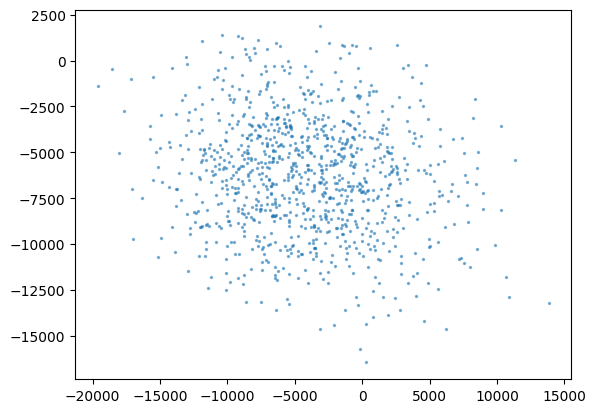

In [31]:
# 更好的做法：直接在不計算梯度的環境下執行
with torch.no_grad():
    samples = annealed_langevin_dynamics(model, sigmas)
    
# 這樣出來的 samples 預設就不會帶梯度，但為了保險起見 (且可能在 GPU 上)，
# 還是建議加上 .cpu().numpy()
samples_np = samples.cpu().numpy()

plt.scatter(samples_np[:, 0], samples_np[:, 1], s=2, alpha=0.5)
plt.show()